# SCOG Trip Generation

## Cross-class trip rates

michael.mccarthy@rsginc.com


In [1]:
# setup
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def freqPlot(df, var, query=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    if query != None:
        data = df.query(query)
    else: 
        data = df
    
    counts = data[var].value_counts()
    axes.bar(counts.index, counts.values)
    axes.set_title(var)
    axes.set_xlabel(var)
    axes.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# from Bishoy
def GetTripRatesUsingOneVars(hh_df, trips_df, x, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1

    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
    HH_PivotTable = hh_df.groupby([x])['hh_weight'].sum().reset_index()
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    Trip_PivotTable = trips_df.groupby([x])['trip_weight'].sum().reset_index()
    
    if cat == "trip":
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')

    else:
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')
        result_table['trips_rate'] = result_table['trip_weight']/result_table['hh_weight']
    result_table=result_table.fillna(0)
        
    return result_table

def GetTripRatesUsingTwoVars(hh_df, trips_df, x, y, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1
    y: x-class variable no. 2, if any!
    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
   
    HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
                        columns=[x], aggfunc=np.sum)     # population
    # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    dta = "trip_weight"
    Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],
                    columns=[x], aggfunc=np.sum, dropna=False)     # population

    if cat == "trip":
        result_table = Trip_PivotTable
    else:
        result_table = Trip_PivotTable/HH_PivotTable    # get the rates by dividing by the number of hh's in the respective market segment
    result_table=result_table.fillna(0)
    return result_table

# michael
def tripQA(trips_df, lookup_pairs, qa_queries):
    """
        Method for decoding survey codes (trip purpose and mode) and run queries (check reported trip duration/speed) and export sample for QA 

        Parameters:
        trips_df: trips dataframe
        decode: dict of column, lookup pairs, such as {"o_purpose_category": purpose_lookup_dict}

    """

    for dfcol, lookup in lookup_pairs.items():
        trips_df[dfcol+"_decode"] = trips_df[dfcol].map(lookup)

    for dfcol, query in qa_queries.items():
        trips_df[dfcol+"_QA"] = trips_df.eval(query) # return True/False column

    return trips_df

def htsRecordsbyTwoVars(trips_df, count_field, x, y, groups):
     # If counting HH records, pass count_field="hh_id" and groups="all"
     # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    Trip_PivotTable = pd.pivot_table(trips_df, values=count_field, index=[y],
                    columns=[x], aggfunc='count', dropna=False)
    
    result_table=Trip_PivotTable.fillna(0)
    return result_table

def htsRecordsbyOneVar(trips_df, count_field, x, groups):
     # If counting HH records, pass count_field="hh_id" and groups="all"
     # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()
    
    Trip_PivotTable = trips_df.groupby([x])[count_field].count().reset_index()
    
    result_table=Trip_PivotTable.fillna(0)
    return result_table



In [3]:
# read in survey tables: households and trips

#trips = pd.read_csv('data/trip.csv')
#hh = pd.read_csv('data/hh.csv')
persons = pd.read_csv('data/person.csv')
days = pd.read_csv('data/day.csv')

# processed trips and HH tables
trips = pd.read_csv('SCOG_HTS_trips.csv')
hh = pd.read_csv('SCOG_HTS_hh.csv')

## Trip Purposes

In [4]:
trips['model_purpose'].value_counts()

model_purpose
HBO     3058
NHBO    1487
HBW      527
NHBW     510
Loop      12
Name: count, dtype: int64

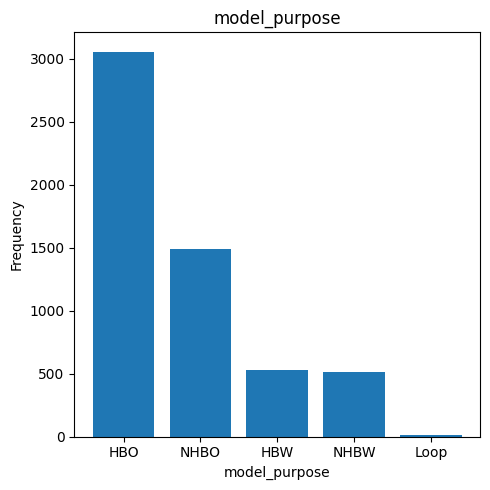

In [5]:
freqPlot(trips,'model_purpose')

In [6]:
# trips by market segment and day of week
markettab = trips.pivot_table(index='market_segment',columns='travel_dow',values='trip_weight', aggfunc='sum')
markettab

# markettab.to_clipboard()

travel_dow,2,3,4
market_segment,,,
II,118149.313949,106209.892332,101222.416258


In [7]:
trips = trips[(trips['market_segment']=='II') & (trips['travel_dow'].isin([2, 3, 4]))]
len(trips)

5594

In [8]:
hh['hh_inc'].value_counts()

hh_inc
INC4    233
INC3    102
INC2     90
INC1     56
NR       54
Name: count, dtype: int64

In [17]:
# income imputation
nohhinc = hh[hh['hh_inc'] == "NR"]
nohhinc_trips = trips[trips['hh_id'].isin(nohhinc['hh_id'])]

hbo_recs = nohhinc_trips[nohhinc_trips['model_purpose'] == "HBO"]
print('HBO trip records: ',len(hbo_recs))
print('HBO trip weight: ',hbo_recs['trip_weight'].sum())

nhbo_recs = nohhinc_trips[nohhinc_trips['model_purpose'] == "NHBO"]
print('NHBO trip records: ',len(nhbo_recs))
print('NHBO trip records: ',nhbo_recs['trip_weight'].sum())

hbo_all = trips[trips['model_purpose'] == "HBO"]
nhbo_all = trips[trips['model_purpose'] == "NHBO"]

print('HBO total trip records: ',len(hbo_all))
print('HBO total trip weight: ',hbo_all['trip_weight'].sum())

print('NHBO total trip records: ',len(nhbo_all))
print('NHBO total trip weight: ',nhbo_all['trip_weight'].sum())

print('All trip records: ',len(trips))
print('All trip weight: ',trips['trip_weight'].sum())


HBO trip records:  263
HBO trip weight:  14503.519629838433
NHBO trip records:  126
NHBO trip records:  7140.206352745664
HBO total trip records:  3058
HBO total trip weight:  165445.38661602268
NHBO total trip records:  1487
NHBO total trip weight:  87042.66391202773
All trip records:  5594
All trip weight:  325581.6225395183


## Prepare Trip Rates by HH Category

Join HH categories to trips


In [10]:
hbw1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "w_size" , groups = "HBW", cat ="triprate")
hbw1D_trip_rates

,w_size,hh_weight,trip_weight,trips_rate
0,1,13090.527935,8590.358005,0.656227
1,2,12286.788283,17985.581819,1.463815
2,3,2200.861430,6232.591082,2.831887


In [ ]:
# HBW without work-related
hbw_trips = trips[(trips['model_purpose'] == 'HBW') & ~(trips['o_purpose_category'] == 3) & ~(trips['d_purpose_category'] == 3)]

hbwnr1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=hbw_trips,
            x = "w_size" , groups = "HBW", cat ="triprate")
hbwnr1D_trip_rates

In [93]:
hbo2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "HBO", cat ="triprate")
hbo2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:61: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:71: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.392074,4.092586,1.709491,9.072162
INC2,2.117904,3.335166,5.311455,5.664549
INC3,2.908945,4.215983,3.610093,9.291220
INC4,1.686848,2.857384,2.610294,7.933930
NR,2.381830,3.380527,5.685492,8.291951


In [94]:
nhbw2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "w_size" , y = "hh_size", groups = "HBO", cat ="triprate")
nhbw2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:61: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:71: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


w_size,0,1,2,3
hh_size,,,,
1,2.798838,1.645952,0.000000,0.000000
2,4.564784,3.394797,2.253964,0.000000
3,6.201858,5.661870,3.122636,1.975433
4,6.656588,9.302367,6.712867,6.093660


In [95]:
nhbo2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "HBO", cat ="triprate")
nhbo2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:61: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:71: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.392074,4.092586,1.709491,9.072162
INC2,2.117904,3.335166,5.311455,5.664549
INC3,2.908945,4.215983,3.610093,9.291220
INC4,1.686848,2.857384,2.610294,7.933930
NR,2.381830,3.380527,5.685492,8.291951


## Trip rate checks

In [96]:
# all purposes (check)

all1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "w_size" , groups = "all", cat ="triprate")
all1D_trip_rates


,w_size,hh_weight,trip_weight,trips_rate
0,0,12318.946614,81201.458485,6.591591
1,1,13090.527935,114152.413139,8.720230
2,2,12286.788283,106917.685202,8.701842
3,3,2200.861430,23310.065714,10.591337


In [97]:

all2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "all", cat ="triprate")
all2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:61: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:71: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,5.123547,6.920249,7.096358,15.175033
INC2,5.040379,6.757415,7.881802,9.513288
INC3,5.284746,6.949409,10.568915,22.242239
INC4,3.713889,6.639096,8.459739,12.843513
NR,4.892172,8.482575,9.865070,11.154475


In [98]:


all2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "w_size" , y = "hh_size", groups = "all", cat ="triprate")
all2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:61: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_5916\1996493132.py:71: FutureWarning: The provided callable <function sum at 0x00000252776BDF80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


w_size,0,1,2,3
hh_size,,,,
1,5.270193,4.449810,0.000000,0.000000
2,7.270179,6.264283,7.012809,0.000000
3,9.184033,9.513121,7.657855,9.744480
4,9.880221,15.361666,11.943170,13.081325


In [99]:
# unweighted total trips/HH

hhPersons_df = pd.merge(hh, persons, left_on='hh_id', right_on='hh_id', how='outer')

HTS_df = pd.merge(trips, hhPersons_df, left_on=['person_id','person_num', 'hh_id'], 
                  right_on=['person_id','person_num', 'hh_id'])

day_weight = days.filter(['hh_id', 'day_num', 'day_weight'])
day_weight

HTS_dayWeighted_df = pd.merge(HTS_df, day_weight, left_on=['hh_id','day_num'], 
                  right_on=['hh_id','day_num'])

hh_weekdays = hh[hh['hh_id'].isin(HTS_dayWeighted_df['hh_id'].unique())]
hh_weekdays

,Unnamed: 0,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,bike_store_other_object,bike_store_rack,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc
0,0,995,995,995,995,995,995,995,995,995,...,2,4,1,1,530579519002,1,35.051069,3,2,INC3
1,3,995,995,995,995,995,995,995,995,995,...,0,4,1,1,530579512001,1,38.606460,1,0,INC2
2,5,995,995,995,995,995,995,995,995,995,...,1,1,997,1,530579514002,1,396.977400,1,1,INC1
3,7,995,995,995,995,995,995,995,995,995,...,0,4,2,4,530579406001,2,104.360304,1,0,INC1
4,8,0,0,1,0,1,0,0,0,0,...,1,1,1,1,530579521002,1,29.122993,1,1,INC4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,666,0,0,1,0,1,0,0,0,0,...,0,1,1,1,530579511004,1,27.915906,2,0,NR
531,667,1,0,1,0,1,0,0,0,0,...,0,4,1,1,530579513001,1,51.829844,2,0,INC4
532,668,0,0,1,0,1,0,0,0,0,...,2,4,1,1,530579524023,1,317.026426,4,2,INC4
533,670,995,995,995,995,995,995,995,995,995,...,0,4,1,1,530579408001,2,65.368398,2,0,INC2


In [100]:
Overall_rates_weighted = HTS_dayWeighted_df['trip_weight'].sum()/hh_weekdays['hh_weight'].sum()
Overall_rates_weighted

np.float64(24.083222875599343)

In [101]:
Overall_rates_Unweighted = len(HTS_dayWeighted_df['trip_id'].unique())/len(hh_weekdays['hh_id'].unique())
Overall_rates_Unweighted

10.45607476635514

## Trip and HH record counts

In [102]:
triprecsHBW = htsRecordsbyOneVar(trips_df=trips, count_field='trip_id', x = "w_size", groups = "HBW")
triprecsHBW

,w_size,trip_id
0,1,276
1,2,224
2,3,27


In [103]:
hhrecsHBW = htsRecordsbyOneVar(trips_df=hh, count_field='hh_id', x = "w_size", groups = "all")
hhrecsHBW

,w_size,hh_id
0,0,225
1,1,197
2,2,104
3,3,9


In [104]:
# HH making HBW trips
HBW_trips = trips[trips['model_purpose'] == "HBW"]
HBW_hh_id = HBW_trips['hh_id'].unique()
HBW_hh = hh[hh['hh_id'].isin(HBW_hh_id)]
HBW_hh.groupby('w_size')['hh_id'].count().reset_index()

,w_size,hh_id
0,1,100
1,2,73
2,3,7


In [105]:
triprecsHBO = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "hh_size" , y = "hh_inc", groups = "HBO")
triprecsHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,108,51,7,62
INC2,115,185,120,73
INC3,206,211,72,79
INC4,109,709,159,529
NR,42,142,23,56


In [106]:
hhrecsHBO = htsRecordsbyTwoVars(trips_df=hh, count_field='hh_id', x = "hh_size" , y = "hh_inc", groups = "all")
hhrecsHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,38,10,4,4
INC2,36,37,9,8
INC3,42,41,11,8
INC4,35,140,27,31
NR,15,32,3,4


In [107]:
triprecsNHBW = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "w_size" , y = "hh_size", groups = "NHBW")
triprecsNHBW

w_size,1,2,3
hh_size,,,
1,121.0,0.0,0.0
2,93.0,129.0,0.0
3,11.0,11.0,21.0
4,27.0,69.0,28.0


In [108]:
hhrecsNHBW = htsRecordsbyTwoVars(trips_df=hh, count_field='hh_id', x = "w_size" , y = "hh_size", groups = "all")
hhrecsNHBW

w_size,0,1,2,3
hh_size,,,,
1,97.0,69.0,0.0,0.0
2,115.0,79.0,66.0,0.0
3,10.0,19.0,19.0,6.0
4,3.0,30.0,19.0,3.0


In [109]:
triprecsNHBO = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "hh_size" , y = "hh_inc", groups = "NHBO")
triprecsNHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,76,23,11,40
INC2,92,92,31,45
INC3,95,75,33,80
INC4,60,340,58,210
NR,27,82,1,16
